In [1]:
import warnings;warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

# 1.데이터 로드

In [2]:
data_path = '../data'
train_path = f'{data_path}/new/new_train_ver3.csv'
test_path  = f'{data_path}/new/new_test_ver3.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
print('Train data shape : ', train_data.shape, 'Test data shape : ', test_data.shape)

# train/test 구분을 위한 칼럼 생성.
train_data['is_test'] = 0
test_data['is_test'] = 1
data = pd.concat([train_data, test_data]) # 하나의 데이터로 합친다.

Train data shape :  (1118822, 42) Test data shape :  (9272, 41)


In [3]:
columns_to_drop = ['k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과',
                   '경비비관리형태', '세대전기계약방법', '청소비관리형태', 'k-시행사']

data['본번'] = data['본번'].astype(int)
data['부번'] = data['부번'].astype(int)

df = data.drop(columns=columns_to_drop)

# 2.컬럼별 처리

## 2-1.본번

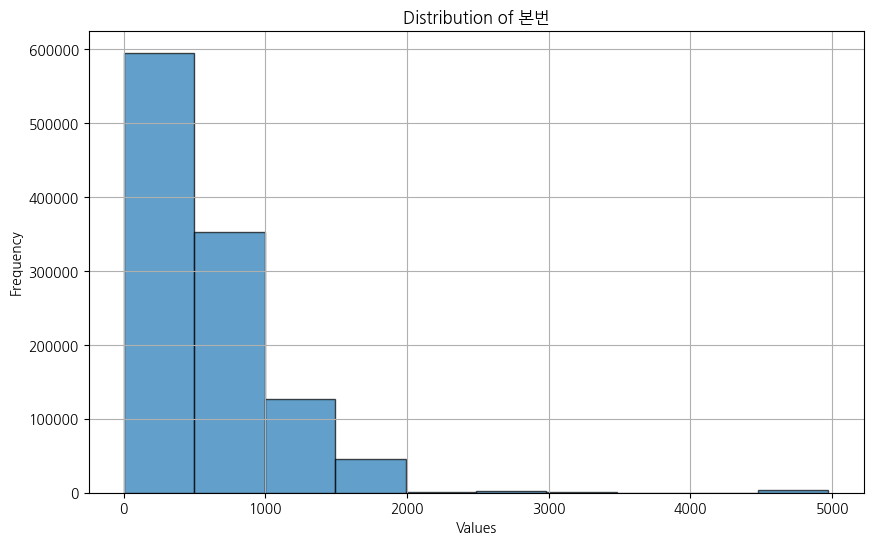

In [4]:
plt.figure(figsize=(10, 6))
plt.hist(df['본번'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 본번')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

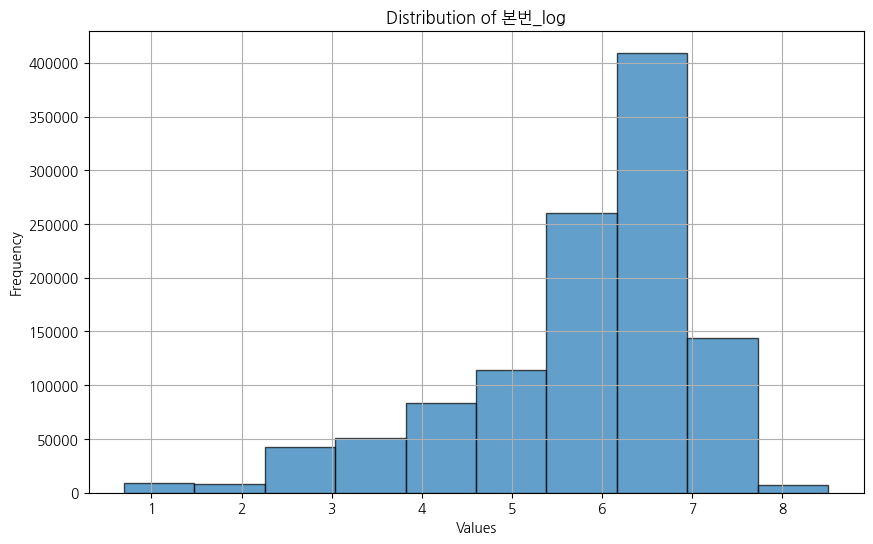

In [5]:
df['본번_log'] = np.log1p(df['본번'])

plt.figure(figsize=(10, 6))
plt.hist(df['본번_log'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 본번_log')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

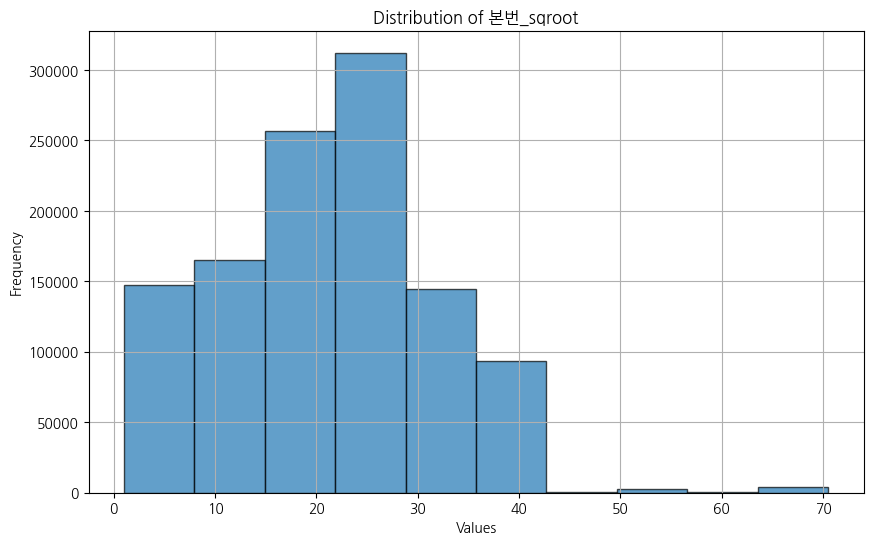

In [6]:
df['본번_sqroot'] = np.sqrt(df['본번'])

plt.figure(figsize=(10, 6))
plt.hist(df['본번_sqroot'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 본번_sqroot')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

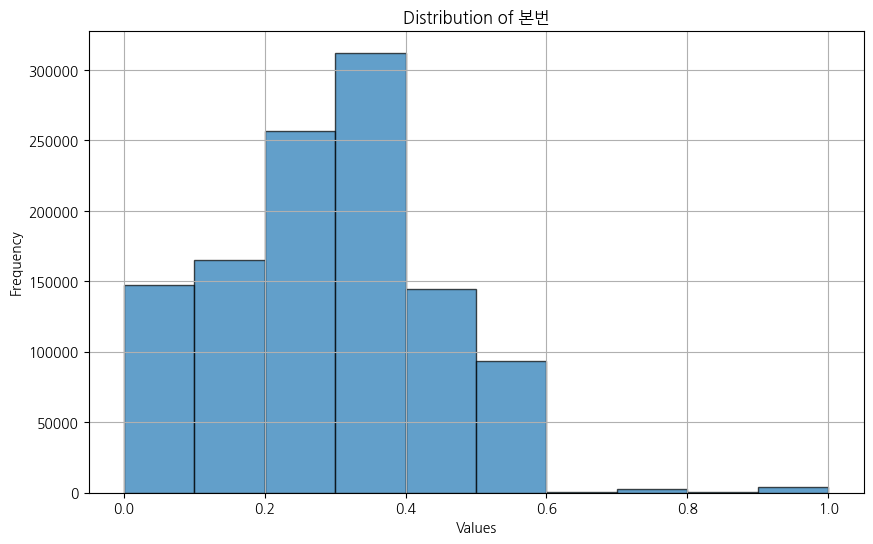

In [7]:
scaler = MinMaxScaler()
df['본번'] = scaler.fit_transform(df[['본번_sqroot']])

plt.figure(figsize=(10, 6))
plt.hist(df['본번'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 본번')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [8]:
df = df.drop(columns=['본번_log', '본번_sqroot'])
print(df.columns)

Index(['본번', '부번', '아파트명', '전용면적', '층', '건축년도', '도로명', '해제사유발생일', '등기신청일자',
       '거래유형', '부동산유형', '분양형태', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수',
       'k-전체세대수', 'k-건설사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-등록일자', 'k-수정일자', '건축면적', '주차대수', '단지승인일', '좌표X', '좌표Y', '단지신청일',
       'target', '구', '동', '계약날짜', 'is_test'],
      dtype='object')


In [9]:
print(df.shape)

(1128094, 35)


## 2-2.부번

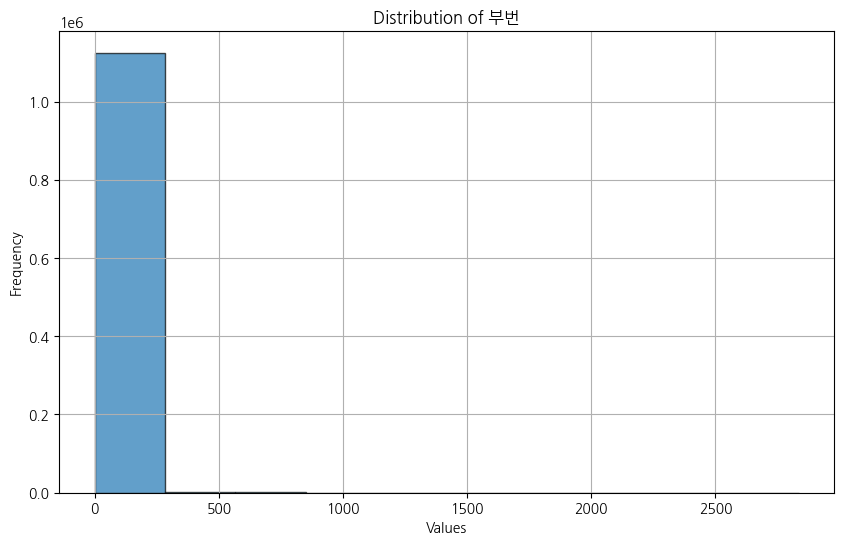

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(df['부번'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 부번')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

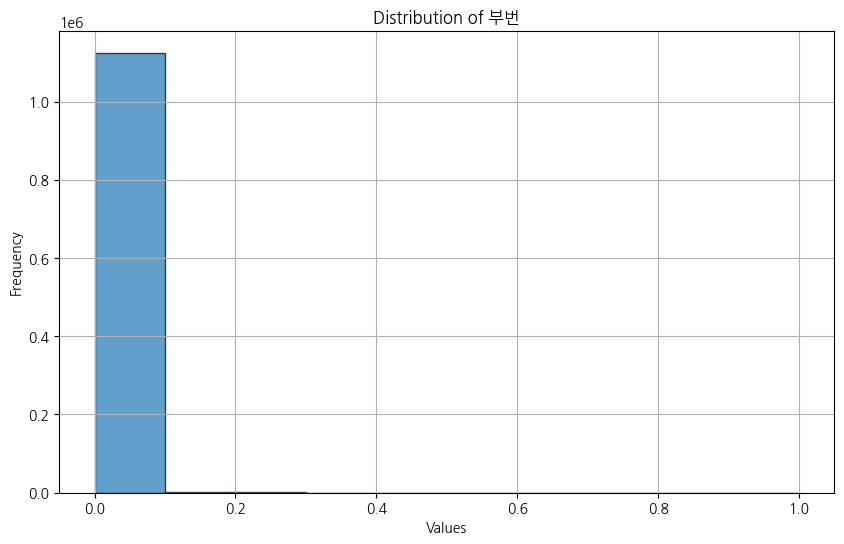

In [11]:
scaler = MinMaxScaler()
df['부번'] = scaler.fit_transform(df[['부번']])

plt.figure(figsize=(10, 6))
plt.hist(df['부번'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 부번')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [12]:
print(df.shape)

(1128094, 35)


## 2-3.전용면적

In [13]:
df['전용면적'].value_counts()

전용면적
84.9600    20593
84.9700    20093
84.9900    19491
84.9800    19238
59.9400    13974
           ...  
83.4530        1
15.9420        1
27.5500        1
59.9833        1
84.9626        1
Name: count, Length: 14670, dtype: int64

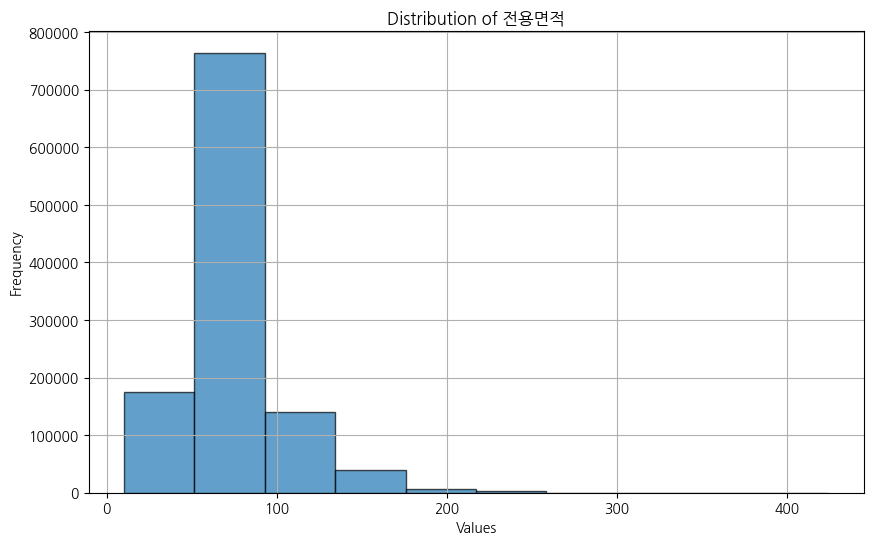

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(df['전용면적'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 전용면적')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

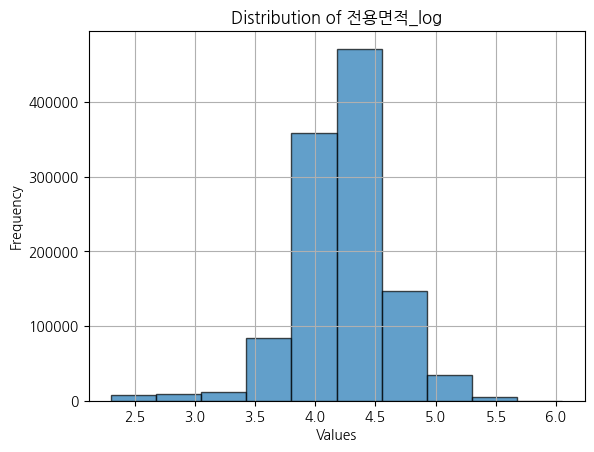

In [15]:
df['전용면적_log'] = np.log(df['전용면적'])

plt.hist(df['전용면적_log'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 전용면적_log')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [16]:
print(df.columns)

Index(['본번', '부번', '아파트명', '전용면적', '층', '건축년도', '도로명', '해제사유발생일', '등기신청일자',
       '거래유형', '부동산유형', '분양형태', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수',
       'k-전체세대수', 'k-건설사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-등록일자', 'k-수정일자', '건축면적', '주차대수', '단지승인일', '좌표X', '좌표Y', '단지신청일',
       'target', '구', '동', '계약날짜', 'is_test', '전용면적_log'],
      dtype='object')


In [17]:
df = df.drop(columns=['전용면적_log'])
df['전용면적'] = np.log(df['전용면적'])
print(df.columns)

Index(['본번', '부번', '아파트명', '전용면적', '층', '건축년도', '도로명', '해제사유발생일', '등기신청일자',
       '거래유형', '부동산유형', '분양형태', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수',
       'k-전체세대수', 'k-건설사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-등록일자', 'k-수정일자', '건축면적', '주차대수', '단지승인일', '좌표X', '좌표Y', '단지신청일',
       'target', '구', '동', '계약날짜', 'is_test'],
      dtype='object')


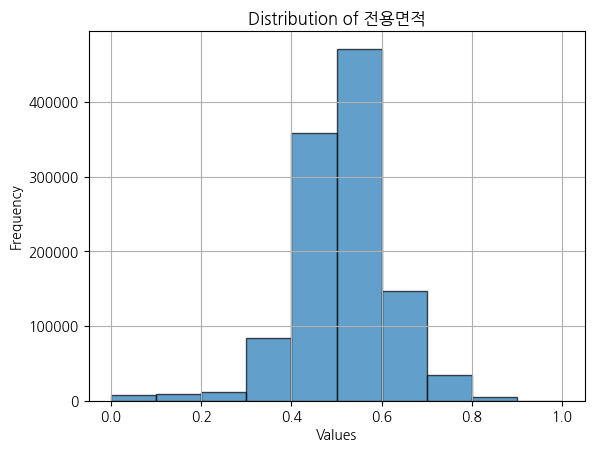

In [18]:
scaler = MinMaxScaler()
df['전용면적'] = scaler.fit_transform(df[['전용면적']])

plt.hist(df['전용면적'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 전용면적')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [19]:
print(df.shape)

(1128094, 35)


## 2-3.계약날짜

부동산 거래를 한 시점이므로 금리나 GDP와 같은 데이터와 연계하는데 사용가능할듯. 대신 추가 정보가 데이터프레임에 추가되고 나서는 삭제하거나 시계열로 다루는 기준이 될 뿐 학습에 직접적으로 반영되지는 않을듯

In [20]:
df['계약날짜'].info

<bound method Series.info of 0       2017-12-08
1       2017-12-22
2       2017-12-28
3       2018-01-03
4       2018-01-08
           ...    
9267    2023-07-19
9268    2023-07-25
9269    2023-08-27
9270    2023-09-02
9271    2023-09-04
Name: 계약날짜, Length: 1128094, dtype: object>

In [21]:
df['계약날짜'] = pd.to_datetime(df['계약날짜'], format='%Y-%m-%d')

In [22]:
df['계약날짜'].info

<bound method Series.info of 0      2017-12-08
1      2017-12-22
2      2017-12-28
3      2018-01-03
4      2018-01-08
          ...    
9267   2023-07-19
9268   2023-07-25
9269   2023-08-27
9270   2023-09-02
9271   2023-09-04
Name: 계약날짜, Length: 1128094, dtype: datetime64[ns]>

In [23]:
oldest_date = df['계약날짜'].min()
most_recent_date = df['계약날짜'].max()

print(oldest_date, most_recent_date)

2007-01-01 00:00:00 2023-09-26 00:00:00


In [24]:
base_date = base_date = pd.Timestamp('2006-12-31')
df['계약날짜_경과일'] = (df['계약날짜'] - base_date).dt.days
# df.drop(columns=['계약날짜'], inplace=True)

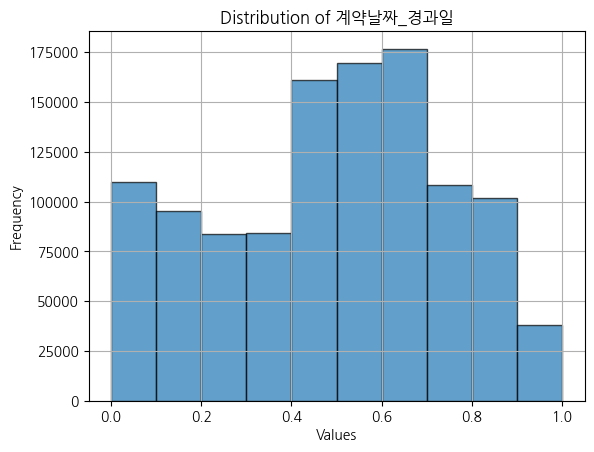

In [25]:
scaler = MinMaxScaler()
df['계약날짜_경과일'] = scaler.fit_transform(df[['계약날짜_경과일']])

plt.hist(df['계약날짜_경과일'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 계약날짜_경과일')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [26]:
print(df.shape)

(1128094, 36)


## 2-4.층

In [27]:
print(df['층'].min(), df['층'].max())
print(df['층'].value_counts())

-4 69
층
 5     82748
 4     82633
 3     81089
 2     77575
 6     74215
       ...  
 65        6
 67        6
 68        6
-4         4
 69        2
Name: count, Length: 73, dtype: int64


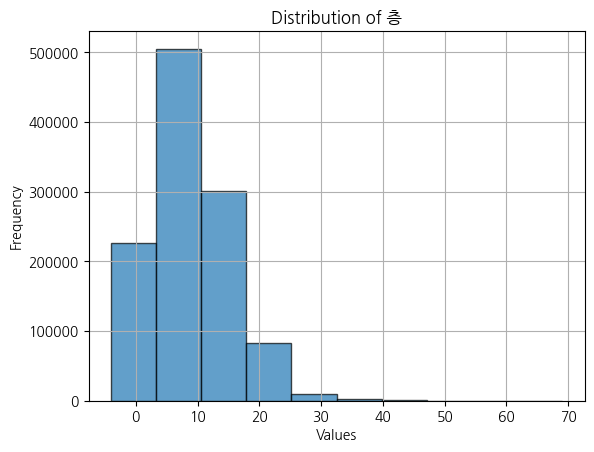

In [28]:
plt.hist(df['층'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 층')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

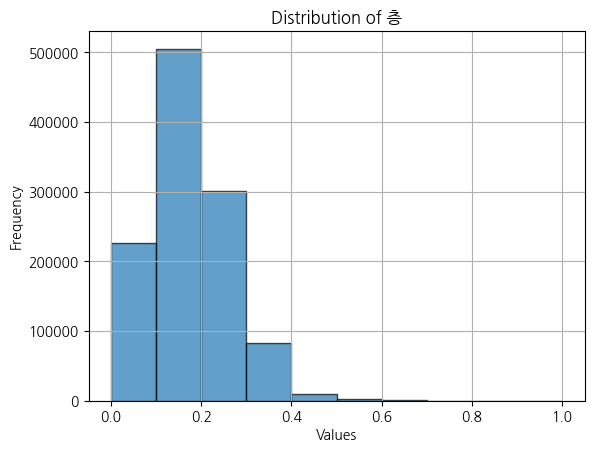

In [29]:
scaler = MinMaxScaler()
df['층'] = scaler.fit_transform(df[['층']])

plt.hist(df['층'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 층')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [30]:
print(df.shape)

(1128094, 36)


## 2-5.구, 동, 분양형태, 부동산유형, k-관리방식, k-난방방식, k-복도유형,  부동산유형, 거래유형

In [31]:
le = LabelEncoder()

df['구'] = le.fit_transform(df['구'])
df['동'] = le.fit_transform(df['동'])
df['분양형태'] = le.fit_transform(df['분양형태'])
df['부동산유형'] = le.fit_transform(df['부동산유형'])
df['k-관리방식'] = le.fit_transform(df['k-관리방식'])
df['k-난방방식'] = le.fit_transform(df['k-난방방식'])
df['k-복도유형'] = le.fit_transform(df['k-복도유형'])
df['부동산유형'] = le.fit_transform(df['부동산유형'])
df['거래유형'] = le.fit_transform(df['거래유형'])

In [32]:
df.head()

,본번,부번,아파트명,전용면적,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,...,단지승인일,좌표X,좌표Y,단지신청일,target,구,동,계약날짜,is_test,계약날짜_경과일
0,0.354562,0.000352,개포6차우성,0.554490,0.095890,1987,언주로 3,NaN,,0,...,2022-11-17 13:00:29.0,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0,8,2017-12-08,0,0.653469
1,0.354562,0.000352,개포6차우성,0.554490,0.109589,1987,언주로 3,NaN,,0,...,2022-11-17 13:00:29.0,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,0,8,2017-12-22,0,0.655759
2,0.354562,0.000352,개포6차우성,0.454466,0.123288,1987,언주로 3,NaN,,0,...,2022-11-17 13:00:29.0,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,0,8,2017-12-28,0,0.656741
3,0.354562,0.000352,개포6차우성,0.554490,0.109589,1987,언주로 3,NaN,,0,...,2022-11-17 13:00:29.0,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,0,8,2018-01-03,0,0.657723
4,0.354562,0.000352,개포6차우성,0.554490,0.082192,1987,언주로 3,NaN,,0,...,2022-11-17 13:00:29.0,127.05721,37.476763,2022-11-17 10:19:06.0,117000.0,0,8,2018-01-08,0,0.658541


## 2-6.건축년도

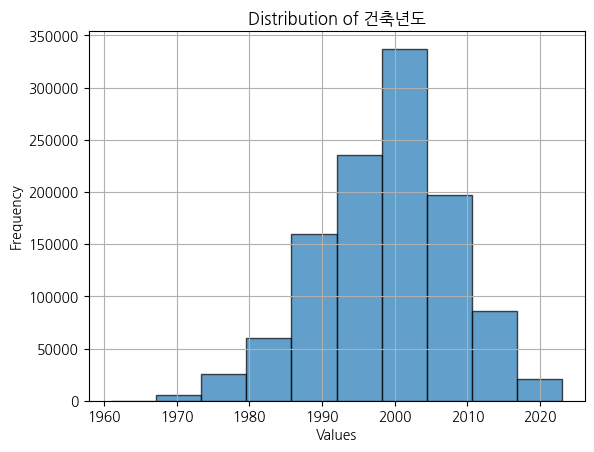

In [33]:
plt.hist(df['건축년도'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 건축년도')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

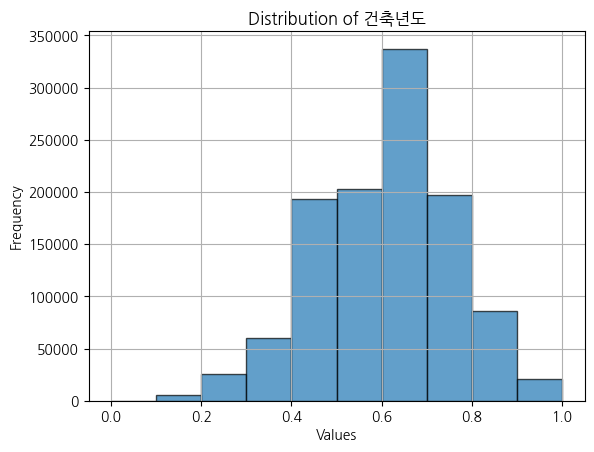

In [34]:
scaler = MinMaxScaler()
df['건축년도'] = scaler.fit_transform(df[['건축년도']])

plt.hist(df['건축년도'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 건축년도')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [35]:
train_df = df[df['is_test'] == 0]
test_df = df[df['is_test'] == 1]

train_df = train_df.drop(columns=['is_test'])
test_df = test_df.drop(columns=['is_test', 'target'])
print(train_df.shape, test_df.shape)

train_df.to_csv(f'{data_path}/new/new_train_ver4.csv', index=False)
test_df.to_csv(f'{data_path}/new/new_test_ver4.csv', index=False)

(1118822, 35) (9272, 34)


In [37]:
train_df.columns

Index(['본번', '부번', '아파트명', '전용면적', '층', '건축년도', '도로명', '해제사유발생일', '등기신청일자',
       '거래유형', '부동산유형', '분양형태', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수',
       'k-전체세대수', 'k-건설사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-등록일자', 'k-수정일자', '건축면적', '주차대수', '단지승인일', '좌표X', '좌표Y', '단지신청일',
       'target', '구', '동', '계약날짜', '계약날짜_경과일'],
      dtype='object')